# Loading required libraries

In [1]:
import os
import cv2
import numpy as np
import pandas as pd
from math import ceil
from time import time
from skimage import color
from tqdm.auto import tqdm
import multiprocessing as mp
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

import timm
import torch
import torchvision
import torchsummary
from torch import nn
from torch.optim import Adam
from torchvision import transforms, utils
from torch.utils.data import Dataset, DataLoader
#from torch.utils.tensorboard import SummaryWriter

from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.ablation_layer import AblationLayerVit
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam import GradCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, EigenGradCAM, LayerCAM

%matplotlib inline

In [6]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cpu'

# Loading Images

In [2]:
valid_img_path = 'dataset/2.validation/2.validation/img/00.png'
valid_mask_path = 'dataset/2.validation/2.validation/mask/00.png'

In [3]:
valid_img = cv2.resize(cv2.imread(valid_img_path), (224, 224))
valid_mask = cv2.cvtColor(cv2.resize(cv2.imread(valid_mask_path), (224, 224)), cv2.COLOR_BGR2RGB)

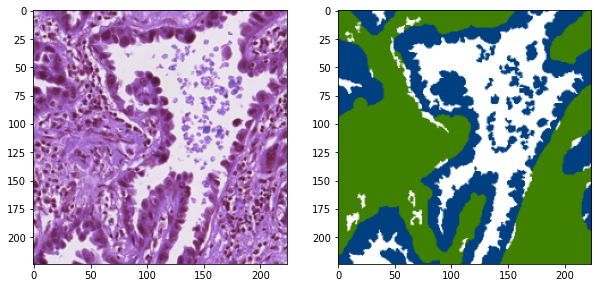

In [4]:
fig = plt.figure(figsize=(10, 10))

ax = fig.add_subplot(1, 2, 1)
plt.imshow(valid_img)

ax = fig.add_subplot(1, 2, 2)
plt.imshow(valid_mask)

# Pre Processing image

In [6]:
def preprocess_image(img: np.ndarray, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], resized = (224, 224)) -> torch.Tensor:
  
  preprocessing = transforms.Compose([
                                      transforms.ToTensor(),
                                      transforms.Resize((224, 224)),
                                      transforms.Normalize(mean, std),
                                      ])
  return preprocessing(img.copy()).unsqueeze(0)


In [7]:
def reshape_transform(tensor, height=7, width=7):
  result = tensor[:, 1 :  , :].reshape(tensor.size(0),
                                       height, width, tensor.size(2))
  
  # Bring the channels to the first dimension,
  # like in CNNs.
  result = result.transpose(2, 3).transpose(1, 2)
  return result

model_weights = ['/home/zephyr/Desktop/Newcastle_University/11_FP_D/Models/' + x for
                 x in os.listdir('/home/zephyr/Desktop/Newcastle_University/11_FP_D/Models') if
                 '32' in x and 'deit' not in x]
model_weights.sort()
model_weights

# Demonstrating all pytorch-grad-cams for the best model

In [7]:
model = timm.create_model('vit_base_patch32_224', pretrained = False, num_classes = 3,
                          drop_rate = 0.2, attn_drop_rate = 0.2).to(device)

In [8]:
model.load_state_dict(torch.load(f='models/model_vit_base_patch32_224_2.pth', map_location=device))

<All keys matched successfully>

In [11]:
%%capture
model.eval()

In [12]:
target_layer = [model.blocks[-1].norm1]
target_layer

[LayerNorm((768,), eps=1e-06, elementwise_affine=True)]

In [13]:
valid_img_tensor = preprocess_image(valid_img, ).to(device)

# Grad-CAM

In [15]:
cam = GradCAM(model = model, target_layers=target_layer,
              reshape_transform=reshape_transform)

In [16]:
valid_cam_0 = cam(input_tensor=valid_img_tensor, targets=[ClassifierOutputTarget(np.array([0]))])
valid_cam_1 = cam(input_tensor=valid_img_tensor, targets=[ClassifierOutputTarget(np.array([1]))])
valid_cam_2 = cam(input_tensor=valid_img_tensor, targets=[ClassifierOutputTarget(np.array([2]))])

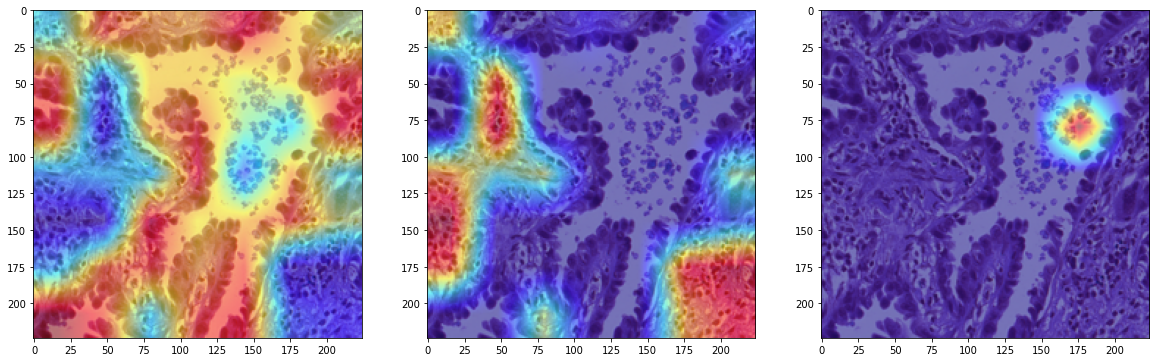

In [17]:
fig = plt.figure(figsize=(20, 40))

ax = fig.add_subplot(1, 3, 1)
plt.imshow(show_cam_on_image(valid_img/255, valid_cam_0[0, :], use_rgb=True))

ax = fig.add_subplot(1, 3, 2)
plt.imshow(show_cam_on_image(valid_img/255, valid_cam_1[0, :], use_rgb=True))

ax = fig.add_subplot(1, 3, 3)
plt.imshow(show_cam_on_image(valid_img/255, valid_cam_2[0, :], use_rgb=True))

# Score-CAM

In [18]:
cam = ScoreCAM(model = model, target_layers=target_layer,
              reshape_transform=reshape_transform)

In [19]:
valid_cam_0 = cam(input_tensor=valid_img_tensor, targets=[ClassifierOutputTarget(np.array([0]))])
valid_cam_1 = cam(input_tensor=valid_img_tensor, targets=[ClassifierOutputTarget(np.array([1]))])
valid_cam_2 = cam(input_tensor=valid_img_tensor, targets=[ClassifierOutputTarget(np.array([2]))])

100%|██████████████████████████████████████████████████████████| 48/48 [01:06<00:00,  1.39s/it]


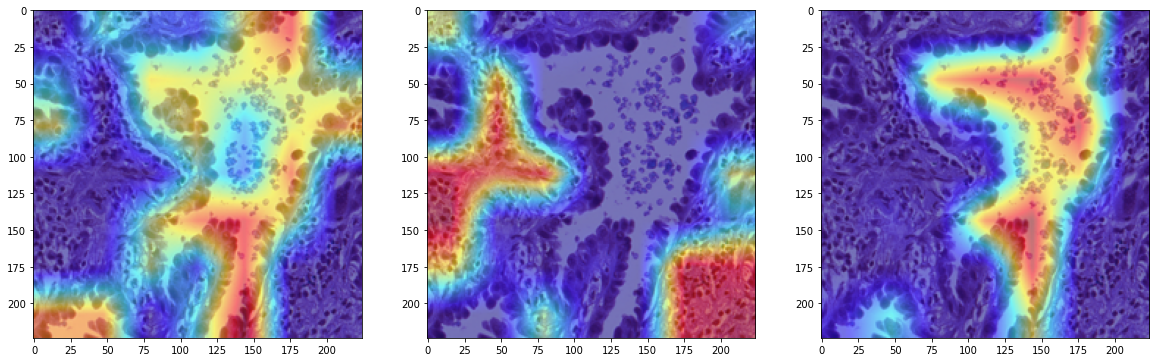

In [20]:
fig = plt.figure(figsize=(20, 40))

ax = fig.add_subplot(1, 3, 1)
plt.imshow(show_cam_on_image(valid_img/255, valid_cam_0[0, :], use_rgb=True))

ax = fig.add_subplot(1, 3, 2)
plt.imshow(show_cam_on_image(valid_img/255, valid_cam_1[0, :], use_rgb=True))

ax = fig.add_subplot(1, 3, 3)
plt.imshow(show_cam_on_image(valid_img/255, valid_cam_2[0, :], use_rgb=True))

# Grad-CAM++

In [21]:
cam = GradCAMPlusPlus(model = model, target_layers=target_layer,
              reshape_transform=reshape_transform)

In [22]:
valid_cam_0 = cam(input_tensor=valid_img_tensor, targets=[ClassifierOutputTarget(np.array([0]))])
valid_cam_1 = cam(input_tensor=valid_img_tensor, targets=[ClassifierOutputTarget(np.array([1]))])
valid_cam_2 = cam(input_tensor=valid_img_tensor, targets=[ClassifierOutputTarget(np.array([2]))])

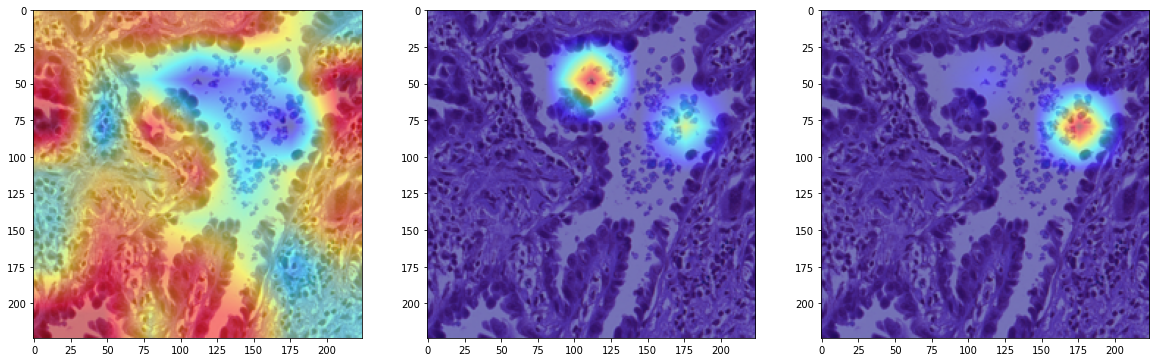

In [23]:
fig = plt.figure(figsize=(20, 40))

ax = fig.add_subplot(1, 3, 1)
plt.imshow(show_cam_on_image(valid_img/255, valid_cam_0[0, :], use_rgb=True))

ax = fig.add_subplot(1, 3, 2)
plt.imshow(show_cam_on_image(valid_img/255, valid_cam_1[0, :], use_rgb=True))

ax = fig.add_subplot(1, 3, 3)
plt.imshow(show_cam_on_image(valid_img/255, valid_cam_2[0, :], use_rgb=True))

# Ablation-CAM

In [14]:
cam = AblationCAM(model = model, target_layers=target_layer,
                  reshape_transform=reshape_transform, ablation_layer=AblationLayerVit())

In [15]:
valid_cam_0 = cam(input_tensor=valid_img_tensor, targets=[ClassifierOutputTarget(np.array([0]))])
valid_cam_1 = cam(input_tensor=valid_img_tensor, targets=[ClassifierOutputTarget(np.array([1]))])
valid_cam_2 = cam(input_tensor=valid_img_tensor, targets=[ClassifierOutputTarget(np.array([2]))])

100%|██████████████████████████████████████████████████████████| 24/24 [01:28<00:00,  3.68s/it]


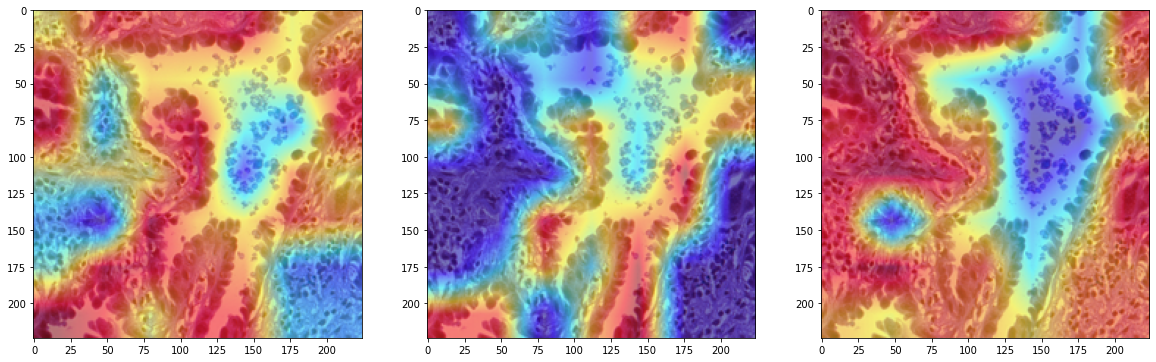

In [16]:
fig = plt.figure(figsize=(20, 40))

ax = fig.add_subplot(1, 3, 1)
plt.imshow(show_cam_on_image(valid_img/255, valid_cam_0[0, :], use_rgb=True))

ax = fig.add_subplot(1, 3, 2)
plt.imshow(show_cam_on_image(valid_img/255, valid_cam_1[0, :], use_rgb=True))

ax = fig.add_subplot(1, 3, 3)
plt.imshow(show_cam_on_image(valid_img/255, valid_cam_2[0, :], use_rgb=True))

# Eigen-CAM++

In [17]:
cam = EigenCAM(model = model, target_layers=target_layer,
              reshape_transform=reshape_transform)

In [18]:
valid_cam_0 = cam(input_tensor=valid_img_tensor, targets=[ClassifierOutputTarget(np.array([0]))])
valid_cam_1 = cam(input_tensor=valid_img_tensor, targets=[ClassifierOutputTarget(np.array([1]))])
valid_cam_2 = cam(input_tensor=valid_img_tensor, targets=[ClassifierOutputTarget(np.array([2]))])

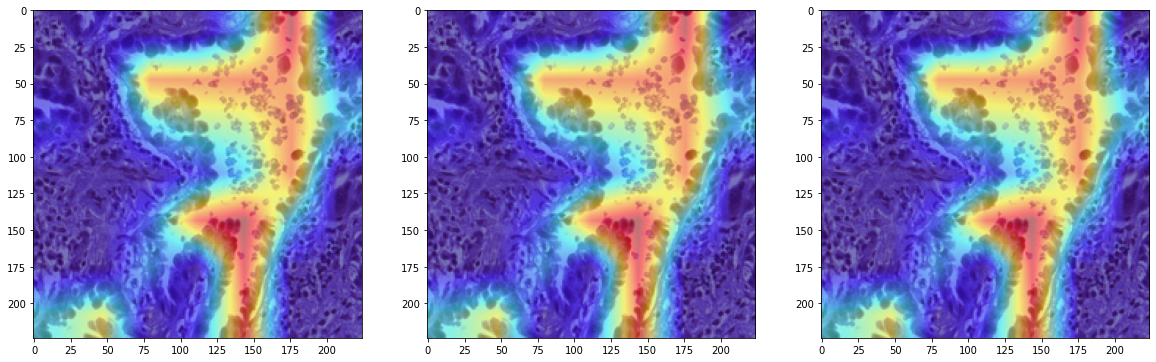

In [19]:
fig = plt.figure(figsize=(20, 40))

ax = fig.add_subplot(1, 3, 1)
plt.imshow(show_cam_on_image(valid_img/255, valid_cam_0[0, :], use_rgb=True))

ax = fig.add_subplot(1, 3, 2)
plt.imshow(show_cam_on_image(valid_img/255, valid_cam_1[0, :], use_rgb=True))

ax = fig.add_subplot(1, 3, 3)
plt.imshow(show_cam_on_image(valid_img/255, valid_cam_2[0, :], use_rgb=True))

# EigenGrad-CAM++

In [20]:
cam = EigenGradCAM(model = model, target_layers=target_layer,
              reshape_transform=reshape_transform)

In [21]:
valid_cam_0 = cam(input_tensor=valid_img_tensor, targets=[ClassifierOutputTarget(np.array([0]))])
valid_cam_1 = cam(input_tensor=valid_img_tensor, targets=[ClassifierOutputTarget(np.array([1]))])
valid_cam_2 = cam(input_tensor=valid_img_tensor, targets=[ClassifierOutputTarget(np.array([2]))])

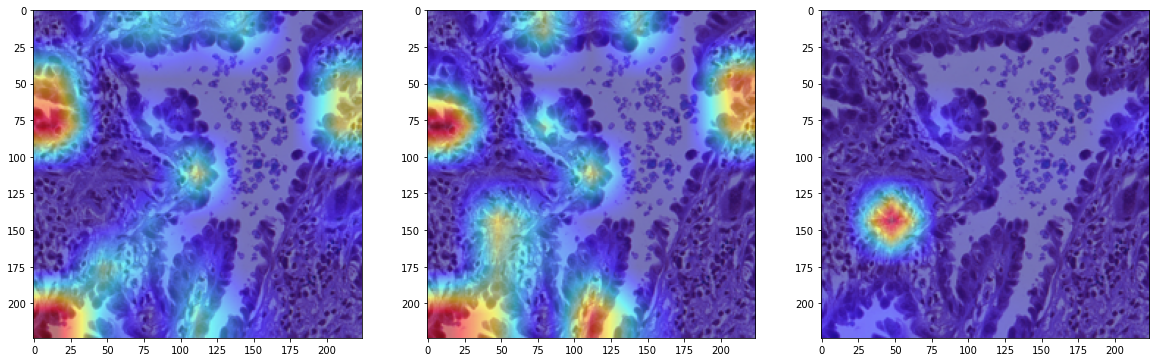

In [22]:
fig = plt.figure(figsize=(20, 40))

ax = fig.add_subplot(1, 3, 1)
plt.imshow(show_cam_on_image(valid_img/255, valid_cam_0[0, :], use_rgb=True))

ax = fig.add_subplot(1, 3, 2)
plt.imshow(show_cam_on_image(valid_img/255, valid_cam_1[0, :], use_rgb=True))

ax = fig.add_subplot(1, 3, 3)
plt.imshow(show_cam_on_image(valid_img/255, valid_cam_2[0, :], use_rgb=True))